In [1]:
# all imports
from bs4 import BeautifulSoup as bs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')
from sklearn.preprocessing import StandardScaler
import os

from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")


In [5]:
# defining functions

# reads xml-data
def read_data(file):
    with open(file, 'r') as f:
        data = f.read()
    bs_data = bs(data, 'xml') 
    return bs_data


# gets the bname for calculations
def get_bname(path):
    for xml_file in os.listdir(path):
        if xml_file.startswith("timeseries"):
            bs_data = read_data(path + xml_file)
            b_name = bs_data.find_all('name')
            return b_name    


# returns a dataframe given some data
def values_df(bs_data, low, high):
    b_name = bs_data.find_all('name')
    attributes = []
    # finds all values 
    for i in range(len(b_name)):
        attributes.append(b_name[i].get('value'))

    attributes = list(attributes)
    collection = {}
    
    # finds x-, y- and z-values and computes euclidian distance
    for i in range(low, high):
        r = calc(b_name, i)
        collection[attributes[i]] = r

    df = pd.DataFrame(collection)
    return df


# calculates the euclidian values
def calc(b_name, i):
    a1 = b_name[i].find_all('component')[0].get('data')
    b1 = b_name[i].find_all('component')[1].get('data')
    c1 = b_name[i].find_all('component')[2].get('data')
    x = np.asarray([float(x) for x in a1.split(',')])
    y = np.asarray([float(y) for y in b1.split(',')])
    z = np.asarray([float(z) for z in c1.split(',')])
    r = (x**2 + y**2 + z**2)**0.5
    return r


# calculates difference between max and min 
def get_differences_values(path, low, high):
    i = 0
    diff_list = []
    
    for xml_file in os.listdir(path):
        if xml_file.startswith("timeseries"):
            try:
                bs_data = read_data(path + xml_file)
                b_name = bs_data.find_all('name')
                
                # fix since these values for some reason don't work when passed as arguments
                if low >= 3*int(len(b_name)/4):
                    low = 3*int(len(b_name)/4)
                    high = int(len(b_name))
                    
                df1 = values_df(bs_data, low, high)

                df_max = pd.DataFrame(df1.max().to_dict(),index=[df1.index.values[-1]])
                df_min = pd.DataFrame(df1.min().to_dict(),index=[df1.index.values[-1]])
                df1 = df_max.subtract(df_min, fill_value=0)
                df1 = df1.rename(index={100:i})

                diff_list.append(df1)
                i+=1
            except:
                 print(xml_file + " failed to compute")
        else:
            continue
            
    if "Healthy" in path:
        injurylevel = [0 for i in range(len(diff_list))]
    else: 
        injurylevel = [1 for i in range(len(diff_list))]
    data_level1 = pd.concat(diff_list)
    data_level1['Injury level'] = injurylevel
    print(f"Length of how many timeseries-files of {path} people we have between files {low} and {high}: {i}")

    return data_level1


# gets accuracy of the algorithms

def get_accuracy(algorithm, data, test_size):
    if algorithm == KNeighborsClassifier:
        classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
    elif algorithm == RandomForestClassifier:
        classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
    else:
        classifier = algorithm()
    y = data['Injury level']
    y = pd.DataFrame(y, columns = ['Injury level'])
    X = data.drop(['Injury level'], axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    my_imputer = SimpleImputer()
    imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
    imputed_X_test = pd.DataFrame(my_imputer.transform(X_test))

    imputed_X_train.columns = X_train.columns
    imputed_X_test.columns = X_test.columns

    sc = StandardScaler()
    X_train = sc.fit_transform(imputed_X_train)
    X_test = sc.transform(imputed_X_test)
    
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    return score

# creating custom datasets

class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    


# returns probability of a person having PFPS
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    
    if y_pred_tag == y_test:
        return True
    else:
        return False

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features = 32, out_features = 16)
        self.fc2 = nn.Linear(in_features = 16, out_features = 8)
        self.out = nn.Linear(in_features = 8, out_features = 1)
        
    def forward(self, t):
        t = t
        
        t = self.fc1(t)
        t = F.relu(t)
        
        t = self.fc2(t)
        t = F.relu(t)
        
        t = self.out(t)
        
        return t


In [7]:
# calculate the four power levels for healthy people:
path = "USE THIS/Healthy/"

b_name = get_bname(path)

diff_list1 = get_differences_values(path, 0, int(len(b_name)/4))
diff_list2 = get_differences_values(path, int(len(b_name)/4), int(len(b_name)/2))
diff_list3 = get_differences_values(path, int(len(b_name)/2), int(3*len(b_name)/4))
diff_list4 = get_differences_values(path, int(3*len(b_name)/4), int(len(b_name)))




# calculate the four power levels for injured people:

path = "USE THIS/PFPS/"

diff_list_injured1 = get_differences_values(path, 0, int(len(b_name)/4))
diff_list_injured2 = get_differences_values(path, int(len(b_name)/4), int(len(b_name)/2))
diff_list_injured3 = get_differences_values(path, int(len(b_name)/2), int(3*len(b_name)/4))
diff_list_injured4 = get_differences_values(path, int(3*len(b_name)/4), len(b_name))


timeseries-10.xml failed to compute
timeseries-44.xml failed to compute
Length of how many timeseries-files of USE THIS/Healthy/ people we have between files 0 and 33: 21
timeseries-10.xml failed to compute
Length of how many timeseries-files of USE THIS/Healthy/ people we have between files 33 and 66: 22
timeseries-10.xml failed to compute
timeseries-23.xml failed to compute
Length of how many timeseries-files of USE THIS/Healthy/ people we have between files 66 and 99: 21
timeseries-10.xml failed to compute
timeseries-23.xml failed to compute
Length of how many timeseries-files of USE THIS/Healthy/ people we have between files 93 and 126: 21
Length of how many timeseries-files of USE THIS/PFPS/ people we have between files 0 and 33: 20
Length of how many timeseries-files of USE THIS/PFPS/ people we have between files 33 and 66: 20
Length of how many timeseries-files of USE THIS/PFPS/ people we have between files 66 and 99: 20
Length of how many timeseries-files of USE THIS/PFPS/ peop

In [8]:
# combine the data into the same dataframes

data_combined = pd.concat([diff_list1, diff_list2, diff_list3, diff_list4])
data2_combined = pd.concat([diff_list_injured1, diff_list_injured2, diff_list_injured3, diff_list_injured4])
data3_combined = pd.concat([data_combined, data2_combined])

data3_level1 = pd.concat([diff_list1, diff_list_injured1]).reset_index(drop = True)
data3_level2 = pd.concat([diff_list2, diff_list_injured2]).reset_index(drop = True)
data3_level3 = pd.concat([diff_list3, diff_list_injured3]).reset_index(drop = True)
data3_level4 = pd.concat([diff_list4, diff_list_injured4]).reset_index(drop = True)


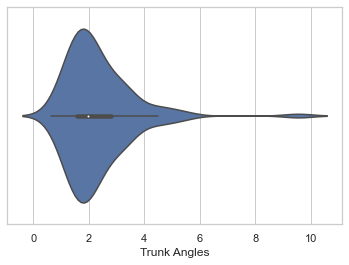

In [13]:
sns.set_theme(style="whitegrid")
ax = sns.violinplot(x=data_combined["Trunk Angles"])

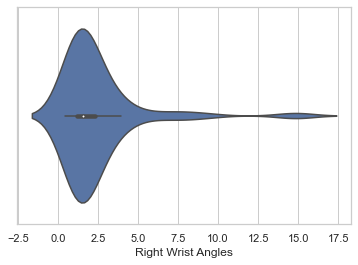

In [14]:
ax = sns.violinplot(x=data_combined["Right Wrist Angles"])

<IPython.core.display.Javascript object>


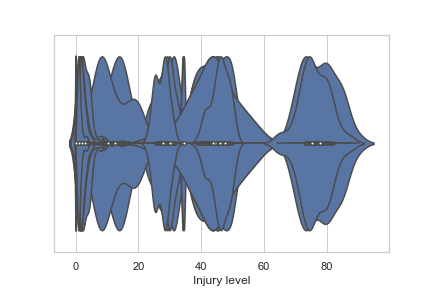

In [50]:
%matplotlib nbagg

for attribute in data_combined: 
    ax = sns.violinplot(x=data_combined[attribute])

<IPython.core.display.Javascript object>


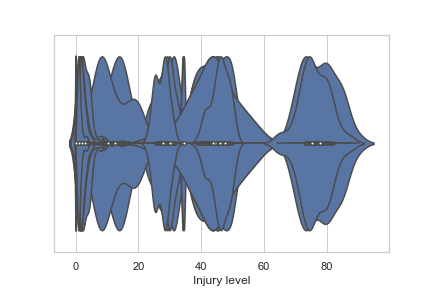

In [51]:
%matplotlib nbagg

for attribute in data2_combined: 
    ax = sns.violinplot(x=data_combined[attribute])

In [43]:
for attribute in data_combined:
    print(attribute)

Head Angles
L_FCC_VLab
L_FM2_VLab
Left Ankle Angles
Left Foot Contact Angle
Left Foot Progression
Left Hip Angles
Left Knee Angles
Left Pelvic Angles
Left Shoulder Angles
Left Shoulder_Pelvis Angle
Left Trunk Angles
Left Trunk Angles_wrt_LAB
Left Wrist Angles
Left_Knee_Ankle_distance
Left_Knee_VLab
PelvisPos
R_FCC_VLab
R_FM2_VLab
Right Ankle Angles
Right Foot Contact Angle
Right Foot Progression
Right Hip Angles
Right Knee Angles
Right Pelvic Angles
Right Shoulder Angles
Right Shoulder_Pelvis Angle
Right Wrist Angles
Right_Knee_Ankle_distance
Right_Knee_VLab
Trunk Angles
Trunk Angles_wrt_LAB
Injury level


<IPython.core.display.Javascript object>


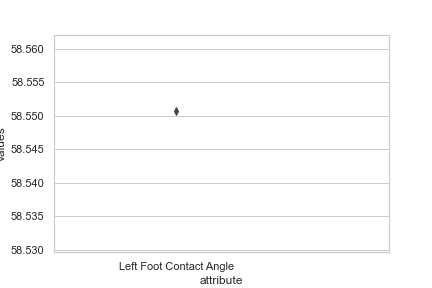

Text(0, 0.5, 'values')

In [52]:
%matplotlib nbagg

df_melted = pd.melt(data_combined)

#create seaborn boxplots by group
sns.boxplot(x='variable', y='value', data=df_melted)
plt.xlabel('attribute')
plt.ylabel('values')



<IPython.core.display.Javascript object>


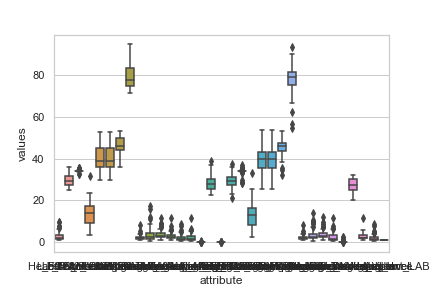

Text(0, 0.5, 'values')

In [33]:
%matplotlib nbagg

df_melted = pd.melt(data2_combined)

#create seaborn boxplots by group
sns.boxplot(x='variable', y='value', data=df_melted)
plt.xlabel('attribute')
plt.ylabel('values')


<IPython.core.display.Javascript object>


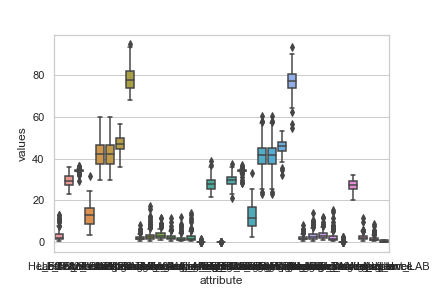

Text(0, 0.5, 'values')

In [37]:
%matplotlib nbagg

df_melted = pd.melt(data3_combined)

#create seaborn boxplots by group
sns.boxplot(x='variable', y='value', data=df_melted)
plt.xlabel('attribute')
plt.ylabel('values')


<IPython.core.display.Javascript object>


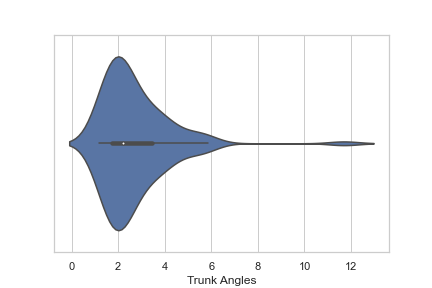

In [39]:
%matplotlib nbagg

sns.set_theme(style="whitegrid")
ax = sns.violinplot(x=data2_combined["Trunk Angles"])

<IPython.core.display.Javascript object>


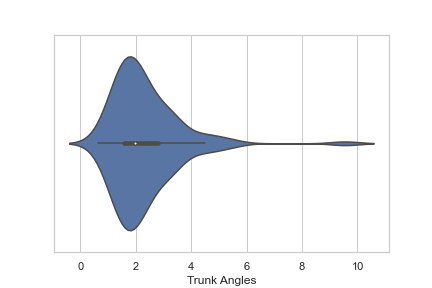

In [40]:
%matplotlib nbagg

sns.set_theme(style="whitegrid")
ax = sns.violinplot(x=data_combined["Trunk Angles"])

<IPython.core.display.Javascript object>


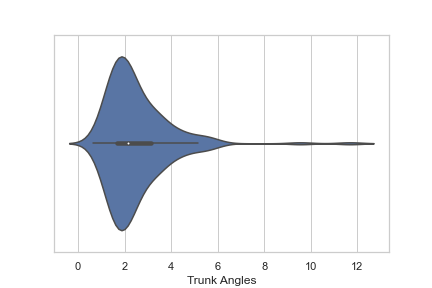

In [41]:
%matplotlib nbagg

sns.set_theme(style="whitegrid")
ax = sns.violinplot(x=data3_combined["Trunk Angles"])

<IPython.core.display.Javascript object>


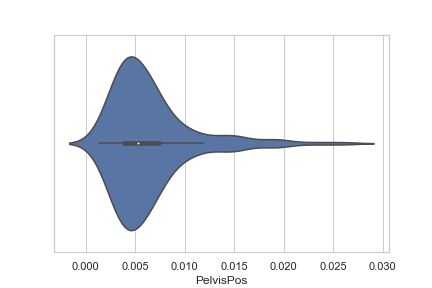

In [44]:
%matplotlib nbagg

sns.set_theme(style="whitegrid")
ax = sns.violinplot(x=data3_combined["PelvisPos"])

<IPython.core.display.Javascript object>


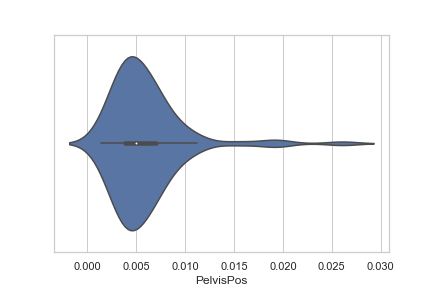

In [45]:
%matplotlib nbagg

sns.set_theme(style="whitegrid")
ax = sns.violinplot(x=data_combined["PelvisPos"])

<IPython.core.display.Javascript object>


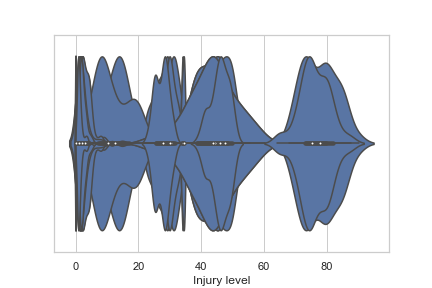

In [46]:
%matplotlib nbagg

sns.set_theme(style="whitegrid")
ax = sns.violinplot(x=data2_combined["PelvisPos"])